In [1]:
!pip install nba-api
!pip install Keras

     |████████████████████████████████| 225kB 9.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [89]:
# dependencies

# basic
from datetime import datetime
import json
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import time

# nba api
import nba_api
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog

# sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

-------
# csv dataset
-------

In [289]:
# df_final = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/gamestatsfinal_version_3.csv')
df_final = pd.read_csv('current_all_boxscores.csv')

In [290]:
df_final

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,CFGA,CFGM,CFG_PCT,COMMENT,...,TEAM_CITY,TEAM_ID,TEAM_NICKNAME,TM_TOV_PCT,TO,TS_PCT,UFGA,UFGM,UFG_PCT,USG_PCT
0,0.227,14.3,1.67,5,2,1,11,5,0.455,NaN,...,Los Angeles,1610612747,Lakers,8.6,3,0.460,10,3,0.300,0.345
1,0.444,23.5,1.60,8,1,2,8,4,0.500,NaN,...,Los Angeles,1610612747,Lakers,14.7,5,0.434,11,3,0.273,0.302
2,0.000,0.0,0.00,0,2,0,3,2,0.667,NaN,...,Los Angeles,1610612747,Lakers,25.0,1,0.667,0,0,0.000,0.103
3,0.000,0.0,0.00,0,1,0,4,3,0.750,NaN,...,Los Angeles,1610612747,Lakers,0.0,0,0.970,10,7,0.700,0.182
4,0.000,0.0,0.00,0,0,0,3,1,0.333,NaN,...,Los Angeles,1610612747,Lakers,22.2,2,0.571,4,2,0.500,0.170
5,0.125,42.9,3.00,3,0,0,0,0,0.000,NaN,...,Los Angeles,1610612747,Lakers,14.3,1,0.000,3,0,0.000,0.058
6,0.059,25.0,0.00,1,1,2,3,1,0.333,NaN,...,Los Angeles,1610612747,Lakers,0.0,0,0.436,0,0,0.000,0.068
7,0.125,12.5,1.00,1,0,0,1,1,1.000,NaN,...,Los Angeles,1610612747,Lakers,12.5,1,0.466,5,1,0.200,0.206
8,0.167,20.0,2.00,2,0,0,3,1,0.333,NaN,...,Los Angeles,1610612747,Lakers,10.0,1,0.286,-3,-1,0.333,0.182
9,0.000,0.0,0.00,0,0,0,0,0,0.000,NaN,...,Los Angeles,1610612747,Lakers,0.0,0,1.500,2,2,1.000,0.065


In [291]:
# fix gameid column w/ leading zeros
df_final['GAME_ID'] = df_final['GAME_ID'].map(lambda x: f'{x:0>10}')

In [292]:
df_final.head()

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,CFGA,CFGM,CFG_PCT,COMMENT,...,TEAM_CITY,TEAM_ID,TEAM_NICKNAME,TM_TOV_PCT,TO,TS_PCT,UFGA,UFGM,UFG_PCT,USG_PCT
0,0.227,14.3,1.67,5,2,1,11,5,0.455,NaN,...,Los Angeles,1610612747,Lakers,8.6,3,0.460,10,3,0.300,0.345
1,0.444,23.5,1.60,8,1,2,8,4,0.500,NaN,...,Los Angeles,1610612747,Lakers,14.7,5,0.434,11,3,0.273,0.302
2,0.000,0.0,0.00,0,2,0,3,2,0.667,NaN,...,Los Angeles,1610612747,Lakers,25.0,1,0.667,0,0,0.000,0.103
3,0.000,0.0,0.00,0,1,0,4,3,0.750,NaN,...,Los Angeles,1610612747,Lakers,0.0,0,0.970,10,7,0.700,0.182
4,0.000,0.0,0.00,0,0,0,3,1,0.333,NaN,...,Los Angeles,1610612747,Lakers,22.2,2,0.571,4,2,0.500,0.170


# feature selection

In [293]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_PCT',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'GAME_ID',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_FGM',
 'PCT_FTA',
 'PCT_FTM',
 'PCT_OREB',
 'PCT_PF',
 'PCT_PFD',
 'PCT_PTS',
 'PCT_REB',
 'PCT_STL',
 'PCT_TOV',
 'PFD',
 'PF',
 'PIE',
 'PLAYER_ID',
 'PLAYER_NAME',
 'PLAYE

In [94]:
features = [
    
#   target
    'WL',
    
#   traditional
    # 'PTS',
    # 'AST',
    'PF',
#   'DEF_RATING',
#   'OFF_RATING',
    'FG_PCT',
    'FG3M',
    'FTM',
    'FGM',
    'STL',
    'TOV',
#     'Home/Away',
    
#   minutes/usage/possession
#     'MIN',
    # 'USG_PCT',
    'POSS',
    
#   point types
    'PTS_2ND_CHANCE',
    'PTS_FB',
    'PTS_OFF_TOV',
    'PTS_PAINT',

#   advanced
    'GAMESCORE',
    'EFG_PCT',
    'TS_PCT',
#   eval => pct above or below team average
#     'EFG_EVAL',
#     'TS_EVAL',
    
#   granular
    'SPD', # speed
    'DIST', # distance
    'ORBC', # oreb chances
    'DRBC', # dreb chances
    'RBC', # reb chances
    'TCHS', # touches
    'SAST', # secondary assists
    'FTAST', # free throw assists
    'PFD', # personal fouls drawn
    'PASS', # passes
    'CFGM', # contested fgm
    'CFGA', # contested fga
    'CFG_PCT', # contested fg pct
    'UFGM', # uncontested fgm
    'UFGA', # uncontested fga
    'UFG_PCT', # uncontested fg pct
    'DFGM', # defended fgm
    'DFGA', # defended fga
    'DFG_PCT', # defended df pct
    
#   percent of team stats
    'PCT_FGM',
    'PCT_FGA',
    'PCT_FG3M',
    'PCT_FG3A',
    'PCT_FTM',
    'PCT_FTA',
    'PCT_OREB',
    'PCT_DREB',
    'PCT_REB',
    'PCT_AST',
    'PCT_TOV',
    'PCT_STL',
    'PCT_BLK',
    'PCT_BLKA',
    'PCT_PF',
    'PCT_PFD',
    'PCT_PTS',
    
#     arena
#     'Capacity_pct',
#     'Capacity',
    
]

In [95]:
len(features)

57

--------
# svc model
--------

In [96]:
df_svc = df_final[features].copy()

In [97]:
df_svc.head()

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.211,0.375,0.167,0.000,0.0,0.500,0.375,0.444,0.190,1.0
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171,1.0
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192,1.0
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134,1.0
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103,1.0


In [98]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
y = encoder.transform(df_svc.WL)
df_svc['y'] = y

In [99]:
encoder = LabelEncoder()
encoder.fit(df_svc['Home/Away'])
home = encoder.transform(df_svc['Home/Away'])
df_svc['HOME'] = home

In [100]:
df_svc

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,y,HOME
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.167,0.000,0.000,0.500,0.375,0.444,0.190,1.000000,1,1
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1.000000,1,1
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1.000000,1,1
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1.000000,1,1
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1.000000,1,1
5,W,5,0.583,2,0,7,2,1,HOME,21,...,0.200,0.667,0.000,0.000,0.500,0.143,0.327,1.000000,1,1
6,W,0,0.000,0,0,0,0,0,HOME,1,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1,1
7,W,0,0.500,1,0,5,0,1,HOME,27,...,0.167,0.000,0.333,0.000,0.000,0.111,0.180,1.000000,1,1
8,W,2,0.500,2,1,2,0,2,HOME,25,...,0.200,0.000,0.000,0.000,0.182,0.125,0.152,1.000000,1,1
9,W,2,0.529,1,4,9,1,1,HOME,29,...,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1.000000,1,1


In [101]:
target = df_svc['y']
data = df_svc.drop(['WL', 'y', 'Home/Away'], axis=1)
feature_names = data.columns

In [102]:
data

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME
0,3,0.429,2,0,3,0,1,19,42,0,...,0.375,0.167,0.000,0.000,0.500,0.375,0.444,0.190,1.000000,1
1,4,0.385,1,1,5,0,2,28,64,2,...,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1.000000,1
2,1,0.333,1,1,4,4,0,25,54,3,...,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1.000000,1
3,1,0.571,0,1,4,0,3,30,68,0,...,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1.000000,1
4,1,0.143,1,2,2,0,3,29,66,0,...,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1.000000,1
5,5,0.583,2,0,7,2,1,21,45,4,...,0.000,0.200,0.667,0.000,0.000,0.500,0.143,0.327,1.000000,1
6,0,0.000,0,0,0,0,0,1,4,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1
7,0,0.500,1,0,5,0,1,27,57,0,...,0.143,0.167,0.000,0.333,0.000,0.000,0.111,0.180,1.000000,1
8,2,0.500,2,1,2,0,2,25,53,3,...,0.429,0.200,0.000,0.000,0.000,0.182,0.125,0.152,1.000000,1
9,2,0.529,1,4,9,1,1,29,64,2,...,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1.000000,1


In [0]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [19]:
y_train.head()

13443    1
6311     0
12709    1
14408    1
11633    0
Name: y, dtype: int64

In [20]:
y_test.head()

20252    0
20634    0
516      1
2250     0
5354     1
Name: y, dtype: int64

In [21]:
X_test

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,Gamescore,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME
20252,3,0.643,2,5,9,0,2,37,77,0,10,4,14,18.6,0.714,0.751,0.173100,0.203600,4.10,2.73,1,4,5,57,0,0,3,39,4,7,0.571,5,7,0.714,4,5,0.800,0.300,0.212,0.200,0.143,0.357,0.333,0.167,0.083,0.100,0.214,0.286,0.0,0.000,0.500,0.136,0.200,0.298,0.851073,0
20634,0,0.182,1,2,2,0,2,20,43,0,0,0,0,0.7,0.227,0.295,-0.259300,-0.272300,4.27,1.53,4,8,12,43,0,0,3,24,0,4,0.000,2,7,0.286,2,5,0.400,0.182,0.282,0.500,0.308,0.333,0.333,0.111,0.211,0.179,0.250,0.250,0.0,0.000,1.000,0.000,0.375,0.233,1.000000,1
516,3,0.500,2,0,4,0,1,23,51,0,5,0,4,5.5,0.625,0.625,0.215200,0.156800,4.51,1.86,0,4,4,40,0,0,0,31,1,1,1.000,3,7,0.429,0,0,0.000,0.286,0.200,0.400,0.286,0.000,0.000,0.000,0.053,0.042,0.182,0.143,0.0,0.000,0.000,0.231,0.000,0.204,0.980567,0
2250,3,0.615,2,1,8,1,7,34,76,0,2,2,8,12.4,0.692,0.684,0.203091,0.167727,3.58,2.17,1,4,5,94,2,0,1,68,4,5,0.800,4,8,0.500,2,2,1.000,0.242,0.228,0.286,0.263,0.071,0.111,0.000,0.154,0.125,0.450,0.467,0.2,0.000,0.000,0.200,0.059,0.218,1.002604,1
5354,0,0.400,0,0,2,0,2,21,43,0,2,0,4,1.6,0.400,0.400,0.037600,-0.015800,4.34,1.59,1,8,9,34,2,0,0,26,1,3,0.333,1,2,0.500,2,3,0.667,0.111,0.125,0.000,0.083,0.000,0.000,0.200,0.176,0.182,0.091,0.400,0.0,0.000,0.333,0.000,0.000,0.078,0.805384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21419,3,0.714,1,0,5,0,3,19,41,0,0,0,8,7.2,0.786,0.786,0.175273,0.164000,4.56,1.53,3,8,11,33,0,0,0,23,2,3,0.667,3,4,0.750,3,5,0.600,0.250,0.212,0.167,0.182,0.000,0.000,0.000,0.222,0.200,0.143,0.375,0.0,0.500,0.000,0.500,0.000,0.224,1.000000,1
18817,4,0.000,0,2,0,0,0,19,39,0,2,0,0,0.7,0.000,0.258,-0.518778,-0.326111,4.50,1.59,2,2,4,19,1,0,1,14,0,1,0.000,0,2,0.000,0,0,0.000,0.000,0.088,0.000,0.200,0.182,0.154,0.333,0.071,0.150,0.143,0.000,0.0,0.000,0.000,0.364,0.100,0.051,1.011036,1
7677,1,0.556,3,2,5,0,1,28,57,3,0,7,4,12.3,0.722,0.759,0.242667,0.261222,4.28,2.15,1,6,7,30,0,0,0,20,2,4,0.500,3,5,0.600,0,0,0.000,0.238,0.191,0.375,0.250,0.133,0.111,0.000,0.176,0.136,0.200,0.111,0.0,0.000,0.000,0.091,0.000,0.231,0.996525,0
13785,1,0.600,2,0,9,0,0,27,52,6,0,2,10,16.0,0.667,0.667,0.025636,0.013182,4.18,1.99,2,8,10,39,0,0,1,23,3,5,0.600,6,10,0.600,4,6,0.667,0.281,0.288,0.250,0.313,0.000,0.000,0.167,0.222,0.208,0.040,0.000,0.0,0.250,0.000,0.167,0.111,0.253,1.000000,1


In [0]:
model = SVC(C= 5, 
        gamma= 0.01, 
        kernel= 'rbf',
        verbose=True)

In [23]:
model.fit(X_train, y_train)

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [0]:
predictions_svc = model.predict(X_test)

In [25]:
X_test['predictions_svc'] = predictions_svc
X_test['target'] = target

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
X_test

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,Gamescore,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME,predictions_svc,target
20252,3,0.643,2,5,9,0,2,37,77,0,10,4,14,18.6,0.714,0.751,0.173100,0.203600,4.10,2.73,1,4,5,57,0,0,3,39,4,7,0.571,5,7,0.714,4,5,0.800,0.300,0.212,0.200,0.143,0.357,0.333,0.167,0.083,0.100,0.214,0.286,0.0,0.000,0.500,0.136,0.200,0.298,0.851073,0,1,0
20634,0,0.182,1,2,2,0,2,20,43,0,0,0,0,0.7,0.227,0.295,-0.259300,-0.272300,4.27,1.53,4,8,12,43,0,0,3,24,0,4,0.000,2,7,0.286,2,5,0.400,0.182,0.282,0.500,0.308,0.333,0.333,0.111,0.211,0.179,0.250,0.250,0.0,0.000,1.000,0.000,0.375,0.233,1.000000,1,1,0
516,3,0.500,2,0,4,0,1,23,51,0,5,0,4,5.5,0.625,0.625,0.215200,0.156800,4.51,1.86,0,4,4,40,0,0,0,31,1,1,1.000,3,7,0.429,0,0,0.000,0.286,0.200,0.400,0.286,0.000,0.000,0.000,0.053,0.042,0.182,0.143,0.0,0.000,0.000,0.231,0.000,0.204,0.980567,0,1,1
2250,3,0.615,2,1,8,1,7,34,76,0,2,2,8,12.4,0.692,0.684,0.203091,0.167727,3.58,2.17,1,4,5,94,2,0,1,68,4,5,0.800,4,8,0.500,2,2,1.000,0.242,0.228,0.286,0.263,0.071,0.111,0.000,0.154,0.125,0.450,0.467,0.2,0.000,0.000,0.200,0.059,0.218,1.002604,1,0,0
5354,0,0.400,0,0,2,0,2,21,43,0,2,0,4,1.6,0.400,0.400,0.037600,-0.015800,4.34,1.59,1,8,9,34,2,0,0,26,1,3,0.333,1,2,0.500,2,3,0.667,0.111,0.125,0.000,0.083,0.000,0.000,0.200,0.176,0.182,0.091,0.400,0.0,0.000,0.333,0.000,0.000,0.078,0.805384,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21419,3,0.714,1,0,5,0,3,19,41,0,0,0,8,7.2,0.786,0.786,0.175273,0.164000,4.56,1.53,3,8,11,33,0,0,0,23,2,3,0.667,3,4,0.750,3,5,0.600,0.250,0.212,0.167,0.182,0.000,0.000,0.000,0.222,0.200,0.143,0.375,0.0,0.500,0.000,0.500,0.000,0.224,1.000000,1,1,0
18817,4,0.000,0,2,0,0,0,19,39,0,2,0,0,0.7,0.000,0.258,-0.518778,-0.326111,4.50,1.59,2,2,4,19,1,0,1,14,0,1,0.000,0,2,0.000,0,0,0.000,0.000,0.088,0.000,0.200,0.182,0.154,0.333,0.071,0.150,0.143,0.000,0.0,0.000,0.000,0.364,0.100,0.051,1.011036,1,1,1
7677,1,0.556,3,2,5,0,1,28,57,3,0,7,4,12.3,0.722,0.759,0.242667,0.261222,4.28,2.15,1,6,7,30,0,0,0,20,2,4,0.500,3,5,0.600,0,0,0.000,0.238,0.191,0.375,0.250,0.133,0.111,0.000,0.176,0.136,0.200,0.111,0.0,0.000,0.000,0.091,0.000,0.231,0.996525,0,0,0
13785,1,0.600,2,0,9,0,0,27,52,6,0,2,10,16.0,0.667,0.667,0.025636,0.013182,4.18,1.99,2,8,10,39,0,0,1,23,3,5,0.600,6,10,0.600,4,6,0.667,0.281,0.288,0.250,0.313,0.000,0.000,0.167,0.222,0.208,0.040,0.000,0.0,0.250,0.000,0.167,0.111,0.253,1.000000,1,1,1


In [27]:
print(classification_report(y_test, predictions_svc, target_names=['Loss','Win']))

              precision    recall  f1-score   support

        Loss       0.57      0.57      0.57      2725
         Win       0.60      0.59      0.59      2891

    accuracy                           0.58      5616
   macro avg       0.58      0.58      0.58      5616
weighted avg       0.58      0.58      0.58      5616



In [28]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'BLK.1',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'Capacity',
 'Capacity_pct',
 'City',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_EVAL',
 'EFG_PCT',
 'EFG_TEAM_AVG',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'FT_missed',
 'GAME_DATE',
 'GAME_ID',
 'Gamescore',
 'Home/Away',
 'Hometeam',
 'MATCHUP',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'MIN_FLAT',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_F

In [0]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [0]:
dfplayerpred = dfpred[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_svc', 'target', 'WL']].copy().dropna()

In [31]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W
...,...,...,...,...,...,...
22434,Tyrone Wallace,Clippers,LAC vs. UTA,1.0,1.0,W
22435,Lou Williams,Clippers,LAC vs. UTA,0.0,1.0,W
22447,Jake Layman,Trail Blazers,POR vs. SAC,0.0,1.0,W
22450,Gary Trent Jr.,Trail Blazers,POR vs. SAC,0.0,1.0,W


In [0]:
dfplayerpred['correct_svc'] = 0

In [0]:
for index, row in dfplayerpred.iterrows():
    
    if row['predictions_svc'] == row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'correct'
    if row['predictions_svc'] != row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'wrong'

In [34]:
dfplayerpred.loc[(dfplayerpred['correct_svc'] == 'correct')]

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL,correct_svc
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W,correct
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W,correct
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L,correct
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L,correct
35,Paul George,Thunder,OKC @ GSW,0.0,0.0,L,correct
...,...,...,...,...,...,...,...
22425,Patrick Beverley,Clippers,LAC vs. UTA,1.0,1.0,W,correct
22427,Danilo Gallinari,Clippers,LAC vs. UTA,1.0,1.0,W,correct
22432,Landry Shamet,Clippers,LAC vs. UTA,1.0,1.0,W,correct
22434,Tyrone Wallace,Clippers,LAC vs. UTA,1.0,1.0,W,correct


## grid

In [103]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [104]:
model = SVC()

# param_grid = {'C': [0.001, 0.1, 1, 5, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'kernel':['rbf']}

param_grid = {'C': [0.1, 1, 5],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel':['rbf']}

grid = GridSearchCV(model, param_grid, verbose=3)

In [105]:
grid.fit(X_train, y_train)

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.581, total=  12.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.585, total=  12.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.4s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.579, total=  12.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.560, total=  12.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.551, total=  13.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.554, total=  12.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.505, total=  13.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.505, total=  13.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.505, total=  14.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 5], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [106]:
grid.best_params_

{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}

In [107]:
grid.best_score_

0.6268550397720527

In [108]:
predictions_grid = grid.predict(X_test)

In [109]:
predictions_grid

array([0, 0, 0, ..., 1, 1, 1])

In [110]:
X_test['predictions_grid'] = predictions_grid
X_test['target'] = target

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
print(classification_report(y_test, predictions_grid,
                            target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.63      0.65      0.64      2725
         win       0.66      0.64      0.65      2891

    accuracy                           0.64      5616
   macro avg       0.64      0.64      0.64      5616
weighted avg       0.64      0.64      0.64      5616



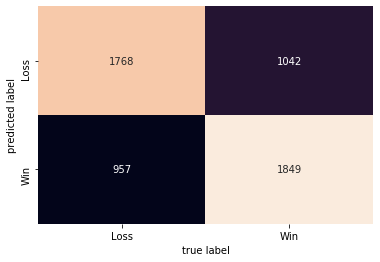

In [112]:
matrix = confusion_matrix(y_test, predictions_grid)
sns.heatmap(matrix.T, annot=True, fmt='d', cbar=False,
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [113]:
matrix.T

array([[1768, 1042],
       [ 957, 1849]])

In [114]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [115]:
dfpred

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME,predictions_grid,target
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.0,1.0,0.000,0.091,0.143,0.134,1.000000,1.0,1.0,1.0
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000,0.0,0.00,0,0,0,0,1,1,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000,0.0,0.00,0,0,0,0,0,0,0.000,...,0.0,0.0,0.000,0.000,0.000,0.000,1.000000,1.0,1.0,1.0
7,0.048,8.3,1.00,1,1,0,1,3,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.250,13.0,3.00,3,0,0,0,5,2,0.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dfplayerpred = dfpred[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_grid', 'target', 'WL']].copy().dropna()

In [119]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL,correct_svc,correct_grid,wrong_grid
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W,correct,0,0
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W,correct,0,0
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L,correct,0,0
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L,correct,0,0
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W,wrong,0,0
34,Terrance Ferguson,Thunder,OKC @ GSW,0.0,0.0,L,correct,0,0
35,Paul George,Thunder,OKC @ GSW,0.0,0.0,L,correct,0,0
41,Eric Bledsoe,Bucks,MIL @ CHA,0.0,1.0,W,wrong,0,0
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.0,1.0,W,wrong,0,0
44,Donte DiVincenzo,Bucks,MIL @ CHA,1.0,1.0,W,correct,0,0


In [134]:
dfplayerpred['correct_grid'] = 0
dfplayerpred['wrong_grid'] = 0

In [135]:
for index, row in dfplayerpred.iterrows():
    
    if row[3] == row['target']:
        dfplayerpred.loc[index, 'correct_grid'] = 1
        
    if row[3] != row['target']:
        dfplayerpred.loc[index, 'wrong_grid'] = 1

    print(index, row[6])

3 correct
6 correct
17 correct
19 correct
31 wrong
34 correct
35 correct
41 wrong
42 wrong
44 correct
46 correct
47 correct
49 wrong
50 correct
54 wrong
57 wrong
59 wrong
72 correct
83 correct
88 correct
90 correct
101 correct
103 correct
115 correct
119 correct
123 wrong
127 correct
128 correct
129 correct
133 wrong
134 wrong
137 wrong
139 correct
140 wrong
169 correct
177 correct
180 correct
194 correct
196 correct
199 correct
200 wrong
205 wrong
208 correct
210 correct
217 correct
218 correct
221 wrong
230 correct
231 correct
239 correct
247 wrong
251 correct
257 correct
259 correct
263 wrong
265 wrong
273 wrong
274 wrong
278 wrong
283 correct
285 correct
286 wrong
290 correct
291 correct
293 correct
300 wrong
308 correct
311 wrong
313 correct
315 wrong
322 wrong
323 correct
326 wrong
327 correct
335 correct
339 correct
341 wrong
344 correct
345 correct
346 correct
351 correct
353 wrong
360 correct
361 wrong
367 wrong
369 correct
379 correct
383 correct
385 correct
387 wrong
396 cor

3468 wrong
3470 wrong
3472 correct
3473 correct
3474 correct
3479 correct
3480 wrong
3481 wrong
3482 wrong
3485 correct
3486 wrong
3488 correct
3489 wrong
3492 correct
3493 wrong
3494 correct
3498 wrong
3501 correct
3502 wrong
3503 wrong
3505 correct
3507 correct
3508 correct
3509 correct
3511 correct
3518 correct
3519 wrong
3522 wrong
3525 wrong
3528 wrong
3529 correct
3532 correct
3533 wrong
3538 wrong
3559 correct
3570 wrong
3571 wrong
3572 wrong
3576 wrong
3578 wrong
3579 wrong
3580 correct
3585 wrong
3588 wrong
3589 correct
3592 wrong
3594 wrong
3609 wrong
3615 correct
3616 correct
3617 correct
3623 correct
3624 wrong
3633 correct
3634 correct
3635 correct
3638 correct
3643 correct
3649 correct
3652 correct
3655 wrong
3662 correct
3668 wrong
3669 correct
3672 correct
3682 correct
3686 correct
3689 wrong
3694 correct
3698 wrong
3699 wrong
3702 correct
3703 wrong
3704 correct
3706 wrong
3707 correct
3710 wrong
3711 correct
3714 wrong
3721 correct
3725 wrong
3728 correct
3733 wrong
3

6775 correct
6778 correct
6779 correct
6781 correct
6790 wrong
6797 wrong
6798 correct
6803 wrong
6808 correct
6812 wrong
6815 correct
6824 correct
6826 correct
6832 correct
6836 wrong
6842 correct
6844 correct
6847 correct
6863 correct
6864 wrong
6868 wrong
6872 correct
6874 correct
6876 correct
6879 wrong
6885 correct
6887 correct
6888 correct
6891 wrong
6892 correct
6896 wrong
6899 correct
6909 correct
6913 wrong
6914 correct
6916 wrong
6918 wrong
6919 correct
6920 wrong
6925 correct
6932 correct
6936 correct
6946 wrong
6947 correct
6951 correct
6956 wrong
6958 wrong
6959 wrong
6964 wrong
6965 wrong
6969 correct
6974 correct
6983 wrong
6987 correct
7003 correct
7007 correct
7014 wrong
7015 wrong
7019 correct
7020 correct
7029 correct
7030 correct
7033 correct
7040 wrong
7047 correct
7048 wrong
7049 wrong
7051 wrong
7071 correct
7072 wrong
7077 correct
7085 wrong
7088 correct
7093 wrong
7094 correct
7097 wrong
7100 wrong
7101 correct
7104 correct
7107 wrong
7109 wrong
7110 correct
71

10119 correct
10120 correct
10127 correct
10130 wrong
10133 correct
10134 wrong
10137 wrong
10138 correct
10140 correct
10144 wrong
10148 wrong
10149 wrong
10157 wrong
10158 wrong
10159 correct
10162 correct
10163 correct
10166 wrong
10168 wrong
10186 correct
10193 correct
10194 correct
10202 correct
10204 correct
10221 wrong
10228 correct
10231 correct
10235 wrong
10244 wrong
10252 correct
10256 wrong
10262 wrong
10263 wrong
10266 wrong
10269 wrong
10272 wrong
10275 correct
10277 correct
10281 wrong
10285 wrong
10299 correct
10300 correct
10309 wrong
10311 correct
10317 correct
10318 correct
10322 correct
10328 correct
10330 correct
10331 correct
10341 wrong
10342 wrong
10346 correct
10351 correct
10353 correct
10354 correct
10363 correct
10365 correct
10373 correct
10376 correct
10378 correct
10381 correct
10384 wrong
10388 correct
10389 correct
10393 correct
10402 wrong
10404 wrong
10408 correct
10418 wrong
10421 correct
10424 correct
10425 wrong
10428 correct
10430 wrong
10431 corr

13805 wrong
13806 correct
13810 correct
13816 wrong
13822 wrong
13826 wrong
13827 correct
13838 correct
13847 correct
13850 correct
13852 correct
13858 correct
13862 correct
13866 correct
13868 correct
13870 wrong
13874 correct
13879 wrong
13880 correct
13882 correct
13885 correct
13888 correct
13897 correct
13903 correct
13908 correct
13912 correct
13914 correct
13922 correct
13924 wrong
13934 correct
13936 correct
13938 correct
13941 correct
13942 wrong
13950 wrong
13955 correct
13963 correct
13967 correct
13976 correct
13977 correct
13978 correct
13980 wrong
13985 wrong
13987 correct
13988 wrong
13995 wrong
13996 correct
13999 correct
14000 correct
14001 correct
14003 correct
14006 correct
14008 correct
14019 correct
14020 wrong
14024 correct
14035 wrong
14044 correct
14046 correct
14047 correct
14070 correct
14071 correct
14076 wrong
14080 wrong
14081 correct
14088 wrong
14091 correct
14093 correct
14094 correct
14099 correct
14100 correct
14105 correct
14111 correct
14112 correct


17381 correct
17383 correct
17384 correct
17392 wrong
17402 correct
17404 correct
17406 correct
17418 correct
17419 correct
17425 correct
17433 correct
17440 correct
17443 wrong
17459 correct
17464 wrong
17469 correct
17473 correct
17487 correct
17488 correct
17492 wrong
17493 wrong
17494 correct
17495 wrong
17497 wrong
17498 correct
17501 correct
17502 correct
17503 wrong
17505 wrong
17510 correct
17511 wrong
17512 correct
17513 correct
17515 correct
17516 correct
17529 correct
17534 wrong
17535 correct
17540 correct
17544 correct
17550 correct
17552 correct
17557 correct
17558 correct
17560 correct
17562 correct
17573 correct
17574 wrong
17578 wrong
17592 correct
17593 wrong
17598 correct
17609 correct
17610 correct
17615 correct
17617 correct
17623 wrong
17624 wrong
17637 correct
17638 wrong
17644 wrong
17645 correct
17654 correct
17655 correct
17659 correct
17662 correct
17663 correct
17666 correct
17667 correct
17669 correct
17672 wrong
17676 correct
17679 correct
17682 correct
17

20771 wrong
20773 correct
20775 correct
20776 wrong
20782 correct
20792 correct
20794 correct
20796 correct
20803 correct
20810 correct
20814 correct
20815 wrong
20818 correct
20820 correct
20823 correct
20829 correct
20836 correct
20837 wrong
20840 correct
20847 correct
20851 correct
20853 correct
20858 correct
20862 correct
20863 correct
20865 wrong
20871 wrong
20874 correct
20882 correct
20891 correct
20895 correct
20900 correct
20901 correct
20902 correct
20905 correct
20909 wrong
20910 wrong
20920 wrong
20922 wrong
20929 correct
20933 wrong
20935 wrong
20941 correct
20942 wrong
20944 wrong
20958 correct
20959 wrong
20962 wrong
20965 wrong
20969 wrong
20970 wrong
20972 correct
20976 correct
20977 wrong
20982 correct
20984 wrong
20993 wrong
21010 correct
21013 wrong
21021 wrong
21024 wrong
21026 correct
21028 wrong
21034 wrong
21038 correct
21041 correct
21043 correct
21047 correct
21058 wrong
21059 correct
21060 correct
21063 correct
21064 correct
21072 correct
21074 correct
21082 

In [136]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL,correct_svc,correct_grid,wrong_grid
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W,correct,1,0
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W,correct,1,0
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L,correct,1,0
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L,correct,1,0
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W,wrong,0,1
34,Terrance Ferguson,Thunder,OKC @ GSW,0.0,0.0,L,correct,1,0
35,Paul George,Thunder,OKC @ GSW,0.0,0.0,L,correct,1,0
41,Eric Bledsoe,Bucks,MIL @ CHA,0.0,1.0,W,wrong,0,1
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.0,1.0,W,wrong,0,1
44,Donte DiVincenzo,Bucks,MIL @ CHA,1.0,1.0,W,correct,1,0


In [137]:
groupbygrid = dfplayerpred.groupby(by='PLAYER_NAME').sum()[['correct_grid', 'wrong_grid']].copy()

In [264]:
df = pd.DataFrame(groupbygrid)
df['differential_grid'] = 0
df['correct_grid_pct'] = 0
df['wrong_grid_pct'] = 0

In [265]:
for index, row in df.iterrows():
    differential = (row['correct_grid'] - row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'differential_grid'] = differential
    
    correct_pct = (row['correct_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'correct_grid_pct'] = correct_pct

    wrong_pct = (row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'wrong_grid_pct'] = wrong_pct


In [266]:
df.sort_values(by='correct_grid_pct').tail(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
E'Twaun Moore,7,1,0.750000,0.875000,0.125000
Miles Bridges,14,2,0.750000,0.875000,0.125000
Maxi Kleber,17,2,0.789474,0.894737,0.105263
De'Aaron Fox,9,1,0.800000,0.900000,0.100000
Robert Covington,10,1,0.818182,0.909091,0.090909
Giannis Antetokounmpo,13,1,0.857143,0.928571,0.071429
DeMar DeRozan,15,1,0.875000,0.937500,0.062500
Drew Eubanks,4,0,1.000000,1.000000,0.000000
Tony Bradley,1,0,1.000000,1.000000,0.000000


In [263]:
df.sort_values(by='wrong_grid_pct').head(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
PJ Dozier,0,1,-1.000000,-1.000000,-1.000000
Ben McLemore,0,4,-1.000000,-1.000000,-1.000000
JaKarr Sampson,0,1,-1.000000,-1.000000,-1.000000
Isaac Bonga,0,1,-1.000000,-1.000000,-1.000000
Cody Zeller,1,7,-0.750000,-0.750000,-0.750000
Isaiah Hartenstein,1,4,-0.600000,-0.600000,-0.600000
Kadeem Allen,1,3,-0.500000,-0.500000,-0.500000
Keita Bates-Diop,3,9,-0.500000,-0.500000,-0.500000
Derrick Jones Jr.,3,7,-0.400000,-0.400000,-0.400000


----------
# neural net
----------

In [204]:
df_nnet = df_final[features]

In [205]:
data = df_nnet.copy()

In [206]:
data.head()

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.211,0.375,0.167,0.000,0.0,0.500,0.375,0.444,0.190,1.0
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171,1.0
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192,1.0
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134,1.0
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103,1.0


In [207]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_
y = encoder.transform(data.WL)
y

array([1, 1, 1, ..., 0, 0, 0])

In [208]:
encoder = LabelEncoder()
encoder.fit(data['Home/Away'])
home = encoder.transform(data['Home/Away'])
data['HOME'] = home

In [209]:
data.drop(columns=['WL','Home/Away'], inplace=True)
# X = data.values
X = data
X

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME
0,3,0.429,2,0,3,0,1,19,42,0,...,0.375,0.167,0.000,0.000,0.500,0.375,0.444,0.190,1.000000,1
1,4,0.385,1,1,5,0,2,28,64,2,...,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1.000000,1
2,1,0.333,1,1,4,4,0,25,54,3,...,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1.000000,1
3,1,0.571,0,1,4,0,3,30,68,0,...,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1.000000,1
4,1,0.143,1,2,2,0,3,29,66,0,...,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1.000000,1
5,5,0.583,2,0,7,2,1,21,45,4,...,0.000,0.200,0.667,0.000,0.000,0.500,0.143,0.327,1.000000,1
6,0,0.000,0,0,0,0,0,1,4,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1
7,0,0.500,1,0,5,0,1,27,57,0,...,0.143,0.167,0.000,0.333,0.000,0.000,0.111,0.180,1.000000,1
8,2,0.500,2,1,2,0,2,25,53,3,...,0.429,0.200,0.000,0.000,0.000,0.182,0.125,0.152,1.000000,1
9,2,0.529,1,4,9,1,1,29,64,2,...,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1.000000,1


In [210]:
len(y), len(X)

(22462, 22462)

In [211]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42)

In [213]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

In [214]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [215]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [216]:
X_train_scaled[0]

array([0.        , 0.667     , 0.        , 0.        , 0.1       ,
       0.        , 0.        , 0.21428571, 0.21367521, 0.        ,
       0.        , 0.        , 0.11111111, 0.21122112, 0.44466667,
       0.44466667, 0.44572269, 0.45770942, 0.66512346, 0.20794393,
       0.09090909, 0.13793103, 0.15384615, 0.10447761, 0.        ,
       0.        , 0.05555556, 0.11340206, 0.0625    , 0.04      ,
       1.        , 0.05882353, 0.07407407, 0.5       , 0.        ,
       0.10526316, 0.        , 0.25      , 0.158     , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.111     ,
       0.111     , 0.        , 0.        , 0.        , 0.667     ,
       0.        , 0.        , 0.25      , 0.2       , 0.90556212,
       1.        ])

In [217]:
y_train_scaled[0]

array([0., 1.], dtype=float32)

In [218]:
X_train_scaled.shape, y_train_scaled.shape

((16846, 56), (16846, 2))

In [219]:
model = Sequential(name='NBA_Model')

# input layer
model.add(Dense(units=50, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

# hidden layers
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))

# output layer
# model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [220]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                2850      
_________________________________________________________________
dense_15 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 52

In [221]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [222]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
#     loss='binary_crossentropy',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [223]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_data=[X_test_scaled, y_test_scaled]
)

Train on 16846 samples, validate on 5616 samples
Epoch 1/100
16846/16846 - 1s - loss: 0.6704 - accuracy: 0.5918 - val_loss: 0.6566 - val_accuracy: 0.6202
Epoch 2/100
16846/16846 - 1s - loss: 0.6440 - accuracy: 0.6283 - val_loss: 0.6212 - val_accuracy: 0.6578
Epoch 3/100
16846/16846 - 1s - loss: 0.6264 - accuracy: 0.6496 - val_loss: 0.6096 - val_accuracy: 0.6629
Epoch 4/100
16846/16846 - 1s - loss: 0.6129 - accuracy: 0.6643 - val_loss: 0.6163 - val_accuracy: 0.6615
Epoch 5/100
16846/16846 - 1s - loss: 0.6085 - accuracy: 0.6667 - val_loss: 0.6112 - val_accuracy: 0.6658
Epoch 6/100
16846/16846 - 1s - loss: 0.6067 - accuracy: 0.6679 - val_loss: 0.6077 - val_accuracy: 0.6620
Epoch 7/100
16846/16846 - 1s - loss: 0.6033 - accuracy: 0.6702 - val_loss: 0.6176 - val_accuracy: 0.6660
Epoch 8/100
16846/16846 - 1s - loss: 0.6005 - accuracy: 0.6718 - val_loss: 0.5995 - val_accuracy: 0.6727
Epoch 9/100
16846/16846 - 1s - loss: 0.5956 - accuracy: 0.6771 - val_loss: 0.6567 - val_accuracy: 0.6182
Epoch 

Epoch 78/100
16846/16846 - 1s - loss: 0.4573 - accuracy: 0.7723 - val_loss: 0.6560 - val_accuracy: 0.6619
Epoch 79/100
16846/16846 - 1s - loss: 0.4546 - accuracy: 0.7774 - val_loss: 0.6823 - val_accuracy: 0.6489
Epoch 80/100
16846/16846 - 1s - loss: 0.4541 - accuracy: 0.7738 - val_loss: 0.6984 - val_accuracy: 0.6658
Epoch 81/100
16846/16846 - 1s - loss: 0.4505 - accuracy: 0.7799 - val_loss: 0.7181 - val_accuracy: 0.6211
Epoch 82/100
16846/16846 - 1s - loss: 0.4408 - accuracy: 0.7856 - val_loss: 0.7178 - val_accuracy: 0.6489
Epoch 83/100
16846/16846 - 1s - loss: 0.4418 - accuracy: 0.7830 - val_loss: 0.6955 - val_accuracy: 0.6706
Epoch 84/100
16846/16846 - 1s - loss: 0.4372 - accuracy: 0.7850 - val_loss: 0.7051 - val_accuracy: 0.6674
Epoch 85/100
16846/16846 - 1s - loss: 0.4343 - accuracy: 0.7906 - val_loss: 0.7266 - val_accuracy: 0.6617
Epoch 86/100
16846/16846 - 1s - loss: 0.4335 - accuracy: 0.7909 - val_loss: 0.7295 - val_accuracy: 0.6571
Epoch 87/100
16846/16846 - 1s - loss: 0.4347 -

In [224]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

5616/1 - 0s - loss: 0.8931 - accuracy: 0.6423
Neural Network - Loss: 0.7969744815106405, Accuracy: 0.6422720551490784


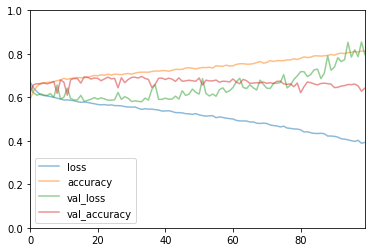

In [225]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()

In [226]:
predictions_nnet = model.predict(X_test_scaled)
predictions_nnet

array([[0.8217973 , 0.17820267],
       [0.04011976, 0.9598802 ],
       [0.66341656, 0.33658338],
       ...,
       [0.47015375, 0.52984625],
       [0.01564208, 0.98435795],
       [0.06111968, 0.93888026]], dtype=float32)

In [227]:
# add predictions to df here and merge with grid pred df
X_test['nnet_pred_loss_0'] = predictions_nnet[:,0]
X_test['nnet_pred_win_1'] = predictions_nnet[:,1]
X_test['WL_TARGET'] = y_test[:,1]

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [228]:
X_test

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET
20252,3,0.643,2,5,9,0,2,37,77,0,...,0.000,0.500,0.136,0.200,0.298,0.851073,0,0.821797,0.178203,0.0
20634,0,0.182,1,2,2,0,2,20,43,0,...,0.000,1.000,0.000,0.375,0.233,1.000000,1,0.040120,0.959880,0.0
516,3,0.500,2,0,4,0,1,23,51,0,...,0.000,0.000,0.231,0.000,0.204,0.980567,0,0.663417,0.336583,1.0
2250,3,0.615,2,1,8,1,7,34,76,0,...,0.000,0.000,0.200,0.059,0.218,1.002604,1,0.859371,0.140629,0.0
5354,0,0.400,0,0,2,0,2,21,43,0,...,0.000,0.333,0.000,0.000,0.078,0.805384,0,0.929992,0.070008,1.0
12136,0,0.000,0,0,0,0,0,0,2,0,...,0.000,0.000,0.000,0.000,0.000,1.000000,1,0.304002,0.695998,1.0
4903,1,0.800,3,1,4,1,3,17,40,0,...,0.500,0.000,0.250,0.125,0.267,0.722648,1,0.094214,0.905786,0.0
2992,4,0.600,2,0,6,0,3,28,63,4,...,1.000,0.500,0.364,0.154,0.212,1.000000,0,0.375756,0.624244,1.0
6239,0,1.000,0,0,2,0,0,4,7,0,...,0.000,0.000,0.000,0.000,1.000,0.803900,0,0.999962,0.000038,1.0
16791,1,0.400,0,2,4,0,3,21,47,4,...,0.000,0.200,0.111,0.125,0.270,1.000000,0,0.958213,0.041786,0.0


In [229]:
dfprednnet = pd.concat([df_final, X_test], axis=1)[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'nnet_pred_loss_0', 'nnet_pred_win_1', 'WL_TARGET', 'WL']].copy().dropna()

In [230]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL
3,Al Horford,Celtics,BOS vs. PHI,0.758751,0.241249,1.0,W
6,Semi Ojeleye,Celtics,BOS vs. PHI,0.345699,0.654301,1.0,W
17,T.J. McConnell,76ers,PHI @ BOS,0.995709,0.004291,0.0,L
19,Dario Saric,76ers,PHI @ BOS,0.948472,0.051528,0.0,L
31,Klay Thompson,Warriors,GSW vs. OKC,0.698419,0.301581,1.0,W
34,Terrance Ferguson,Thunder,OKC @ GSW,0.669562,0.330438,0.0,L
35,Paul George,Thunder,OKC @ GSW,0.944847,0.055154,0.0,L
41,Eric Bledsoe,Bucks,MIL @ CHA,0.126309,0.873691,1.0,W
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.732193,0.267807,1.0,W
44,Donte DiVincenzo,Bucks,MIL @ CHA,0.530375,0.469625,1.0,W


In [231]:
dfprednnet['nnet_eval'] = 0
dfprednnet['nnet_total'] = 1

In [232]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL,nnet_eval,nnet_total
3,Al Horford,Celtics,BOS vs. PHI,0.758751,0.241249,1.0,W,0,1
6,Semi Ojeleye,Celtics,BOS vs. PHI,0.345699,0.654301,1.0,W,0,1
17,T.J. McConnell,76ers,PHI @ BOS,0.995709,0.004291,0.0,L,0,1
19,Dario Saric,76ers,PHI @ BOS,0.948472,0.051528,0.0,L,0,1
31,Klay Thompson,Warriors,GSW vs. OKC,0.698419,0.301581,1.0,W,0,1
34,Terrance Ferguson,Thunder,OKC @ GSW,0.669562,0.330438,0.0,L,0,1
35,Paul George,Thunder,OKC @ GSW,0.944847,0.055154,0.0,L,0,1
41,Eric Bledsoe,Bucks,MIL @ CHA,0.126309,0.873691,1.0,W,0,1
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.732193,0.267807,1.0,W,0,1
44,Donte DiVincenzo,Bucks,MIL @ CHA,0.530375,0.469625,1.0,W,0,1


In [233]:
for index, row in dfprednnet.iterrows():
    
    if dfprednnet.loc[index, 'nnet_pred_loss_0'] > 0.5 and row['WL_TARGET'] == 0.0:
        dfprednnet.loc[index, 'nnet_eval'] = 1
    
    if dfprednnet.loc[index, 'nnet_pred_win_1'] > 0.5 and row['WL_TARGET'] == 1.0:
        dfprednnet.loc[index, 'nnet_eval'] = 1


In [234]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL,nnet_eval,nnet_total
3,Al Horford,Celtics,BOS vs. PHI,0.758751,0.241249,1.0,W,0,1
6,Semi Ojeleye,Celtics,BOS vs. PHI,0.345699,0.654301,1.0,W,1,1
17,T.J. McConnell,76ers,PHI @ BOS,0.995709,0.004291,0.0,L,1,1
19,Dario Saric,76ers,PHI @ BOS,0.948472,0.051528,0.0,L,1,1
31,Klay Thompson,Warriors,GSW vs. OKC,0.698419,0.301581,1.0,W,0,1
34,Terrance Ferguson,Thunder,OKC @ GSW,0.669562,0.330438,0.0,L,1,1
35,Paul George,Thunder,OKC @ GSW,0.944847,0.055154,0.0,L,1,1
41,Eric Bledsoe,Bucks,MIL @ CHA,0.126309,0.873691,1.0,W,1,1
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.732193,0.267807,1.0,W,0,1
44,Donte DiVincenzo,Bucks,MIL @ CHA,0.530375,0.469625,1.0,W,0,1


In [235]:
dfprednnet['nnet_eval'].value_counts() / len(dfprednnet['nnet_eval'])

1    0.642272
0    0.357728
Name: nnet_eval, dtype: float64

In [236]:
len(dfprednnet['nnet_eval'])

5616

In [237]:
groupbynnet = dfprednnet.groupby(by='PLAYER_NAME').sum()[['nnet_eval','nnet_total']].copy()

In [238]:
groupbynnet

,nnet_eval,nnet_total
PLAYER_NAME,,
Aaron Gordon,13,18
Aaron Holiday,3,9
Abdel Nader,7,14
Al Horford,11,17
Al-Farouq Aminu,13,16
Alec Burks,6,13
Alex Caruso,4,9
Alex Len,7,12
Alfonzo McKinnie,8,13


In [280]:
dfnnet = pd.DataFrame(groupbynnet)
dfnnet['differential_nnet'] = 0
dfnnet['nnet_wrong'] = 0
dfnnet['nnet_wrong_pct'] = 0
dfnnet['nnet_correct_pct'] = 0

for index, row in dfnnet.iterrows():
    
    total_nnet = row['nnet_total']
    
    correct_nnet = row['nnet_eval']
    
    wrong_nnet = total_nnet - correct_nnet
    dfnnet.loc[index, 'nnet_wrong'] = wrong_nnet
    
    differential_nnet = (correct_nnet - wrong_nnet) / total_nnet
    dfnnet.loc[index, 'differential_nnet'] = differential_nnet
    
    correct_pct = correct_nnet / total_nnet
    dfnnet.loc[index, 'nnet_correct_pct'] = correct_pct

    wrong_pct = wrong_nnet / total_nnet
    dfnnet.loc[index, 'nnet_wrong_pct'] = wrong_pct

In [281]:
# dfnnet.sort_values(by='differential_nnet').head(20)
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Aaron Gordon,13,18,0.444444,5,0.277778,0.722222
Aaron Holiday,3,9,-0.333333,6,0.666667,0.333333
Abdel Nader,7,14,0.000000,7,0.500000,0.500000
Al Horford,11,17,0.294118,6,0.352941,0.647059
Al-Farouq Aminu,13,16,0.625000,3,0.187500,0.812500
Alec Burks,6,13,-0.076923,7,0.538462,0.461538
Alex Caruso,4,9,-0.111111,5,0.555556,0.444444
Alex Len,7,12,0.166667,5,0.416667,0.583333
Alfonzo McKinnie,8,13,0.230769,5,0.384615,0.615385


## predictions df

In [282]:
df

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
Aaron Gordon,10,8,0.111111,0.555556,0.444444
Aaron Holiday,6,3,0.333333,0.666667,0.333333
Abdel Nader,8,6,0.142857,0.571429,0.428571
Al Horford,12,5,0.411765,0.705882,0.294118
Al-Farouq Aminu,11,5,0.375000,0.687500,0.312500
Alec Burks,5,8,-0.230769,0.384615,0.615385
Alex Caruso,5,4,0.111111,0.555556,0.444444
Alex Len,10,2,0.666667,0.833333,0.166667
Alfonzo McKinnie,6,7,-0.076923,0.461538,0.538462


In [283]:
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Aaron Gordon,13,18,0.444444,5,0.277778,0.722222
Aaron Holiday,3,9,-0.333333,6,0.666667,0.333333
Abdel Nader,7,14,0.000000,7,0.500000,0.500000
Al Horford,11,17,0.294118,6,0.352941,0.647059
Al-Farouq Aminu,13,16,0.625000,3,0.187500,0.812500
Alec Burks,6,13,-0.076923,7,0.538462,0.461538
Alex Caruso,4,9,-0.111111,5,0.555556,0.444444
Alex Len,7,12,0.166667,5,0.416667,0.583333
Alfonzo McKinnie,8,13,0.230769,5,0.384615,0.615385


In [284]:
print('Neural Net Worst:')
pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']].sort_values(by='nnet_correct_pct')

Neural Net Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
JaKarr Sampson,0.000000,0.000000
Tony Bradley,0.000000,1.000000
Ben McLemore,0.000000,0.000000
Isaac Bonga,0.000000,0.000000
Isaiah Hartenstein,0.200000,0.200000
Kadeem Allen,0.250000,0.250000
Ryan Broekhoff,0.250000,0.500000
Markelle Fultz,0.250000,0.750000
Mikal Bridges,0.294118,0.588235


In [279]:
print('SVM Worst:')
pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']].sort_values(by='correct_grid_pct')

SVM Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
PJ Dozier,1.0,0.000000
Ben McLemore,NaN,0.000000
JaKarr Sampson,NaN,0.000000
Isaac Bonga,NaN,0.000000
Cody Zeller,1.0,0.125000
Isaiah Hartenstein,1.0,0.200000
Kadeem Allen,1.0,0.250000
Keita Bates-Diop,1.0,0.250000
Derrick Jones Jr.,1.0,0.300000


In [286]:
print('Neural Net Best:')
pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']].head(100).sort_values(by='nnet_correct_pct', ascending=False)

Neural Net Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Brandon Goodwin,1.000000,0.714286
Danuel House Jr.,1.000000,0.769231
Dillon Brooks,1.000000,1.000000
BJ Johnson,1.000000,1.000000
Chris Boucher,0.875000,0.625000
Dion Waiters,0.875000,0.750000
Danny Green,0.869565,0.739130
Dario Saric,0.833333,0.611111
Andre Iguodala,0.833333,0.833333


In [288]:
print('SVM Best:')
pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']].head(100).sort_values(by='correct_grid_pct', ascending=False)

SVM Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Dillon Brooks,1.000000,1.000000
Anfernee Simons,0.833333,1.000000
BJ Johnson,1.000000,1.000000
Chris Chiozza,0.666667,1.000000
DeMar DeRozan,0.812500,0.937500
De'Aaron Fox,0.800000,0.900000
Collin Sexton,0.695652,0.869565
Buddy Hield,0.800000,0.866667
Andre Iguodala,0.833333,0.833333


# random forest

In [0]:
df_forest = df_final[features].copy()

In [0]:
target = df_forest["WL"]
target_names = ["W", "L"]

In [0]:
encoder = LabelEncoder()
encoder.fit(df_forest['Home/Away'])
home = encoder.transform(df_forest['Home/Away'])
df_forest['HOME'] = home

In [0]:
data = df_forest.drop(["WL",'Home/Away'], axis=1)
feature_names = data.columns
data.head()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [0]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [0]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [0]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)